<a href="https://colab.research.google.com/github/subhayughoshal/Titanic-Prediction-Model/blob/main/Titanic_predictions_subhayu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
sns.set(style='whitegrid')

In [ ]:
# Loading data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
#Data Cleaning
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
test_df['Age'] = test_df['Age'].fillna(train_df['Age'].median())  # Use train median to avoid leakage
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
test_df['Fare'] = test_df['Fare'].fillna(train_df['Fare'].median())  # Test has 1 missing Fare
if 'Cabin' in train_df.columns:
    train_df = train_df.drop('Cabin', axis=1)
if 'Cabin' in test_df.columns:
    test_df = test_df.drop('Cabin', axis=1)

In [ ]:
# Feature Engineering
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + train_df['Parch'] + 1

In [ ]:
# Encode categorical variables
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})
train_df['Embarked'] = train_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
test_df['Embarked'] = test_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# **EDA**

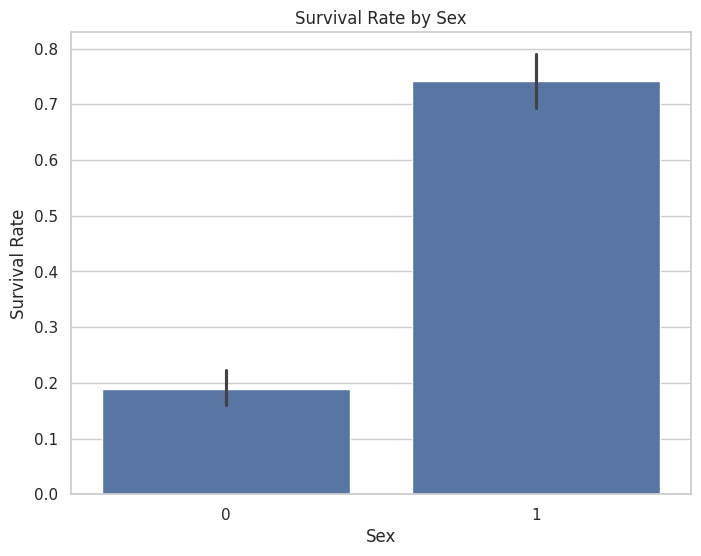

In [ ]:
# 1. Survival by Sex
plt.figure(figsize=(8, 6))
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.title('Survival Rate by Sex')
plt.ylabel('Survival Rate')
plt.show()

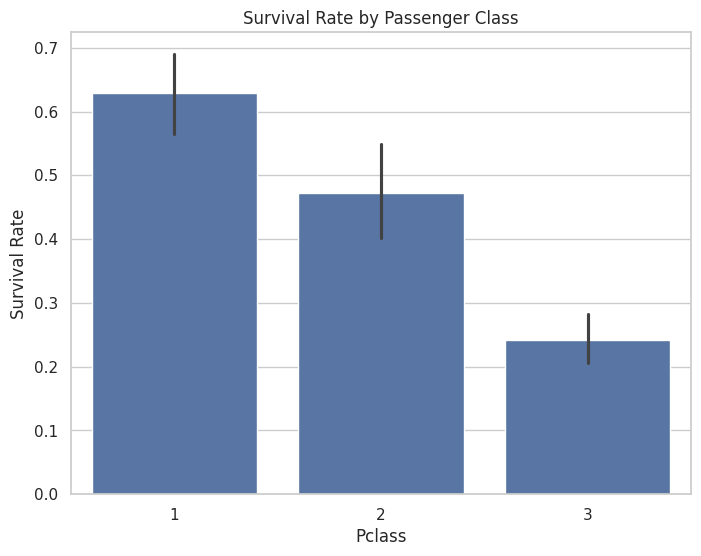

In [ ]:
# 2. Survival by Pclass
plt.figure(figsize=(8, 6))
sns.barplot(x='Pclass', y='Survived', data=train_df)
plt.title('Survival Rate by Passenger Class')
plt.ylabel('Survival Rate')
plt.show()


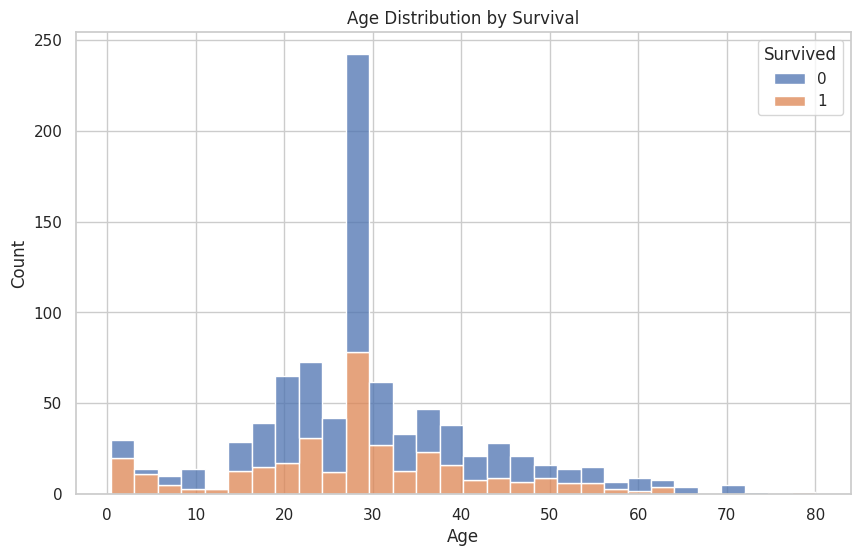

In [ ]:
# 3. Survival by Age
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='Age', hue='Survived', multiple='stack', bins=30)
plt.title('Age Distribution by Survival')
plt.show()

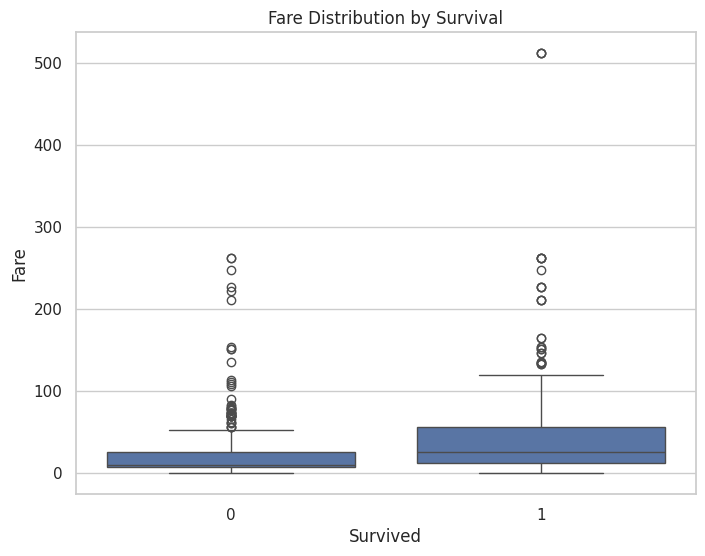

In [ ]:
# Survival bt Fare
plt.figure(figsize=(8, 6))
sns.boxplot(x='Survived', y='Fare', data=train_df)
plt.title('Fare Distribution by Survival')
plt.show()

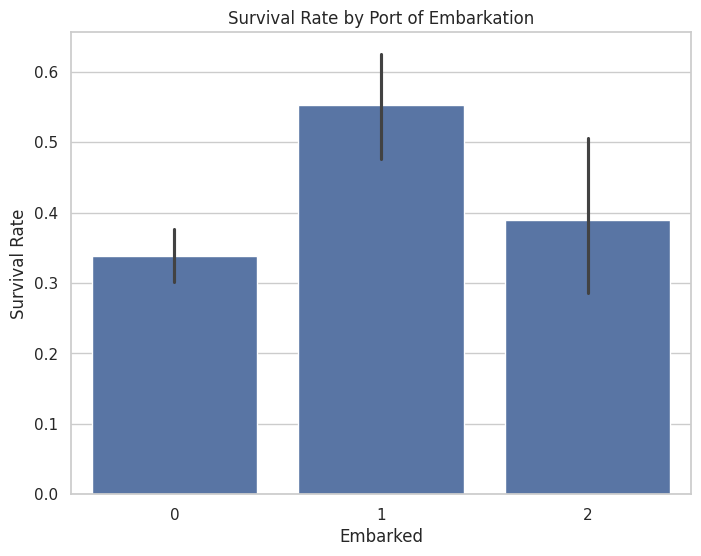

In [ ]:
# 4. Survival by Embarked
plt.figure(figsize=(8, 6))
sns.barplot(x='Embarked', y='Survived', data=train_df)
plt.title('Survival Rate by Port of Embarkation')
plt.ylabel('Survival Rate')
plt.show()


<Axes: xlabel='Pclass', ylabel='Fare'>

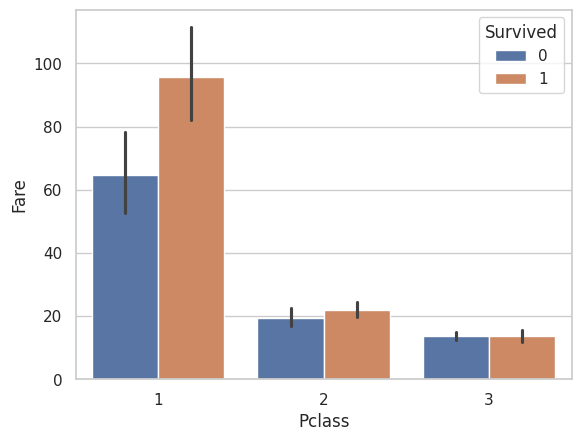

In [ ]:
sns.barplot(data=train_df, x="Pclass", y="Fare", hue="Survived")

In [ ]:
pd.pivot_table(train_df, index="Survived", values=["Age", "SibSp", "Parch", "Fare"])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.028233,22.117887,0.329690,0.553734
1,28.291433,48.395408,0.464912,0.473684


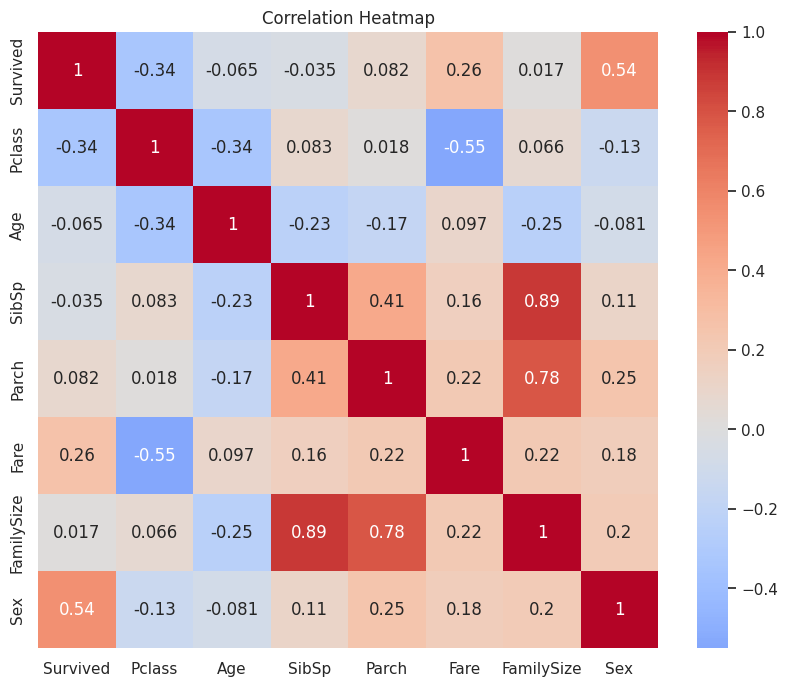

In [ ]:
# Correlation Heatmap
numerical_df = train_df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Sex']]
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Prepare features for modeling
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize']
X = train_df[features].copy()
X_test = test_df[features].copy()

In [ ]:
numerical_cols = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
X[numerical_cols] = X[numerical_cols].astype('float64')
X_test[numerical_cols] = X_test[numerical_cols].astype('float64')

In [ ]:
# Normalize numerical features
scaler = StandardScaler()
X.loc[:, ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']] = scaler.fit_transform(X[['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']])
X_test.loc[:, ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']] = scaler.transform(X_test[['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']])


In [ ]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=200, random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
    'XGBClassifier': XGBClassifier(random_state=42, eval_metric='logloss')
}

In [ ]:
# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    # Validation accuracy
    val_preds = model.predict(X_val)
    acc = accuracy_score(y_val, val_preds)
    # Cross-validation score (5-fold on full train)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_mean = np.mean(cv_scores)
    results[name] = {'val_accuracy': acc, 'cv_mean': cv_mean}
    print(f"{name}: Val Accuracy = {acc:.4f}, CV Mean = {cv_mean:.4f}")

LogisticRegression: Val Accuracy = 0.7989, CV Mean = 0.7935
RandomForestClassifier: Val Accuracy = 0.8212, CV Mean = 0.8092
ExtraTreesClassifier: Val Accuracy = 0.8156, CV Mean = 0.7901
XGBClassifier: Val Accuracy = 0.7989, CV Mean = 0.8171


In [ ]:
# Selecting the best model based on average of val accuracy and CV mean
best_model_name = max(results, key=lambda k: (results[k]['val_accuracy'] + results[k]['cv_mean']) / 2)
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name} with Avg Score: {(results[best_model_name]['val_accuracy'] + results[best_model_name]['cv_mean']) / 2:.4f}")


Best Model: RandomForestClassifier with Avg Score: 0.8152


In [ ]:
# Test predictions and submission
test_preds = best_model.predict(X_test)
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_preds
})
submission.to_csv('my_model_predictions.csv', index=False)
print("\nFirst 5 predictions from best model:")
print(submission.head())


First 5 predictions from best model:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         1
4          896         0


In [ ]:
#Compare with gender_submission.csv
try:
    gender_submission = pd.read_csv('gender_submission.csv')
    agreement = (submission['Survived'] == gender_submission['Survived']).mean()
    print(f"\nAgreement with gender_submission.csv: {agreement*100:.2f}%")
except FileNotFoundError:
    print("gender_submission.csv not found for comparison.")


Agreement with gender_submission.csv: 85.89%


link to the repository: https://github.com/subhayughoshal/Titanic-Prediction-Model/tree/main


link to comprehensive article: https://medium.com/@subhayugh18/predicting-titanic-survival-eda-model-building-ec18e2e8f6b0
